In [2]:
# https://gymnasium.farama.org/environments/classic_control/cart_pole/
# cartpole 공식 document

import time
import gymnasium as gym
import pygame

env = gym.make("CartPole-v1", render_mode="human")
state, info = env.reset()

print("5초 뒤에 에피소드 시작합니다...")

env.render()

start = time.time()
while time.time() - start < 5:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            env.close()
            raise SystemExit
    time.sleep(0.01)

print("에피소드 시작!")

for t in range(500):
    # 랜덤 행동
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            env.close()
            raise SystemExit

    time.sleep(0.02) # 50 FPS

    if terminated or truncated:
        print(f"Episode 끝! {t + 1} step")
        break

print("에피소드 종료, 창을 5초 동안 유지합니다...")

start = time.time()
while time.time() - start < 5:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            env.close()
            raise SystemExit
    time.sleep(0.01)

env.close()

5초 뒤에 에피소드 시작합니다...
에피소드 시작!
Episode 끝! 44 step
에피소드 종료, 창을 5초 동안 유지합니다...


In [3]:
# 위 코드를 100회 시행해서 평균 버틴 steps 수를 보자.
# 여기서는 데이터 시각화를 위해, human render 는 하지 않는다.

import gymnasium as gym
import numpy as np

def run_random_cartpole(num_episodes=100, max_steps=500, seed=None):
    env = gym.make("CartPole-v1")
    if seed is not None:
        np.random.seed(seed)
        env.reset(seed=seed)

    episode_lengths = []

    for ep in range(num_episodes):
        state, info = env.reset()
        steps = 0

        for t in range(max_steps):
            action = env.action_space.sample()
            state, reward, terminated, truncated, info = env.step(action)
            steps += 1

            if terminated or truncated:
                break

        episode_lengths.append(steps)

    env.close()
    return np.array(episode_lengths)

episode_lengths = run_random_cartpole(num_episodes=300)

print("각 에피소드 스텝 수:", episode_lengths)
print("평균 스텝:", episode_lengths.mean())
print("최소 스텝:", episode_lengths.min())
print("최대 스텝:", episode_lengths.max())


각 에피소드 스텝 수: [12 24 30 18 43 15 17 44 12 24 24 19 13 11 34 26 42 38 24 12 18 21 14  9
 46 14 15 30 33 37 13 20 13 26 12 22 48 11 28 18 10 31 23 17 25 15 14 14
 32 16 20 13 74 12 33 12 14 28 21 19 12 16 21 37 31 18 23 27 19 27 26 34
 16 23 42 15 11 47 19 21 10 12 20 11 25 13 26 14 16 15 23 18 15 22 13 24
  9 13 37 17 12 15 12 34 22 19 50 20 11 36 24 76 13 15 31 19 12 20 14 25
 23 34 13 17 18 18 29  9 24 34 11 30 25 16 14 25 69 61 29 21 16 11 15 32
 15 44 43 22 26 35 21 14 55 13 21 12 10 11 19 29 12 24 15 22 24 31 14 20
 17 43 22 12 30 17 15 21 15 19 20 20 11 29 21 15 15 12 18 18  9 21  9 16
 28 23 17 31 19 12 19 14 19 73 11 24  8 17 19  9 14 23 16 27 46 43 25 14
 11 26 11 21 15 13 11 20 19 20 17 27 10 28 11 20 19 16 10 17 22 14 24 13
 32 14 15 37 10 13 12 51 12 11 13 30 72 10 26 44 16 18 14 48 16 50 20 24
 28 18 16 17 27 23 18 14 13 17 23 20 16 41 14 23 33 12 25 16 31 18 27 15
 39 18 12 18 16 28 14 17 28 36 15 28]
평균 스텝: 22.1
최소 스텝: 8
최대 스텝: 76


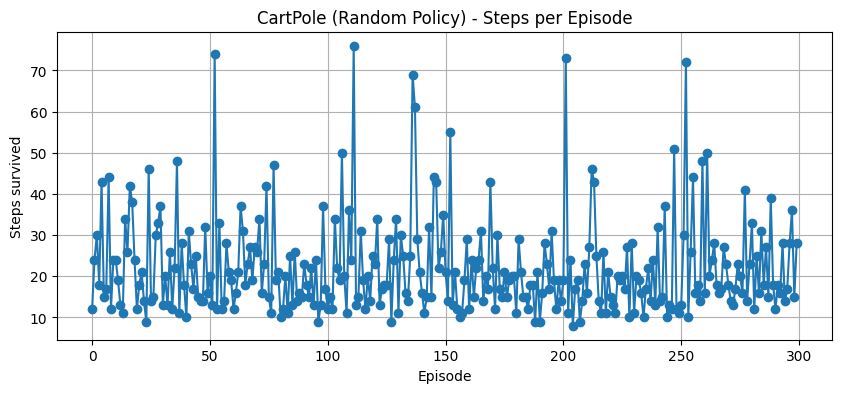

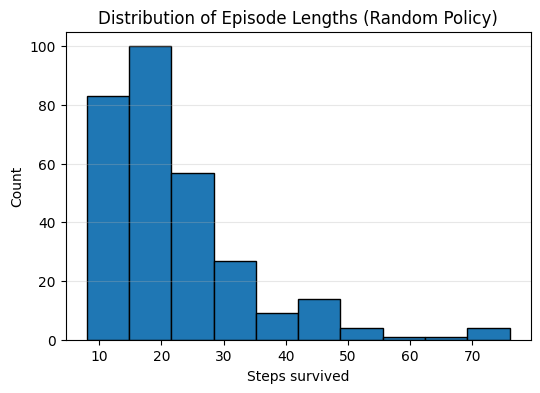

In [4]:
import matplotlib.pyplot as plt

# 1) 에피소드별 스텝 수 라인 그래프
plt.figure(figsize=(10, 4))
plt.plot(episode_lengths, marker="o")
plt.xlabel("Episode")
plt.ylabel("Steps survived")
plt.title("CartPole (Random Policy) - Steps per Episode")
plt.grid(True)
plt.show()

# 2) 스텝 분포 히스토그램
plt.figure(figsize=(6, 4))
plt.hist(episode_lengths, bins=10, edgecolor="black")
plt.xlabel("Steps survived")
plt.ylabel("Count")
plt.title("Distribution of Episode Lengths (Random Policy)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

위 결과는 그냥 랜덤으로 행동할 뿐이기 때문에, 학습이 되지 않는것은 물론이고, 에피소드의 길이가 대부분 아주 짧게 끝난다.

강화학습의 목표는 이 평균 스텝을 올려서, 가능한 오래 게임오버가 되지 않게 하는게 목표이다.

[Linear] Episode 1, new best reward = 10.0
[Linear] Episode 5, new best reward = 500.0
Best linear weights saved to linear_policy_bestW.pkl


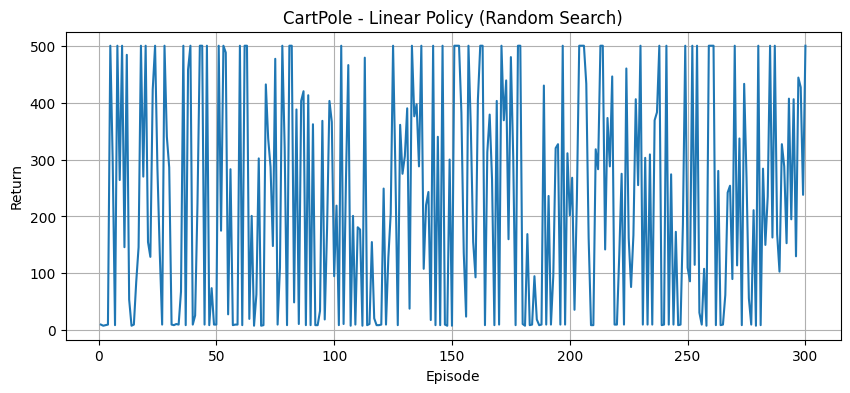

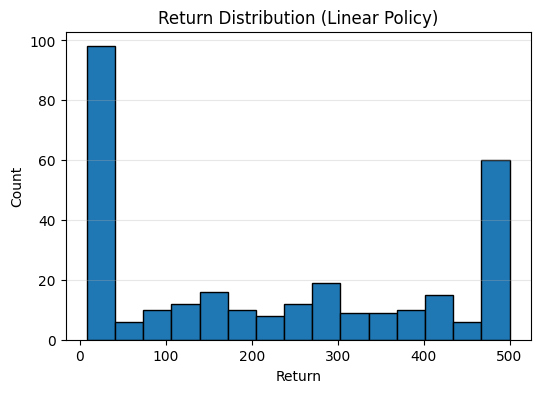

In [5]:
# cartpole_linear_policy.py
# 가장 간단한 선형 정책 + 랜덤 서치

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

ENV_ID = "CartPole-v1"
NUM_EPISODES = 300
MAX_STEPS = 500

def run_episode(env, W, render=False):
    state, info = env.reset()
    total_reward = 0

    for t in range(MAX_STEPS):
        action = 1 if np.dot(W, state) > 0 else 0
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        if render:
            env.render()

        if terminated or truncated:
            break

    return total_reward

def main():
    env = gym.make(ENV_ID)
    best_W = np.random.randn(4) * 0.1
    best_reward = 0

    rewards = []

    for ep in range(1, NUM_EPISODES + 1):
        W_try = best_W + np.random.randn(4) * 0.1
        ep_reward = run_episode(env, W_try)

        if ep_reward > best_reward:
            best_reward = ep_reward
            best_W = W_try
            print(f"[Linear] Episode {ep}, new best reward = {best_reward}")

        rewards.append(ep_reward)

    env.close()

    import os, pickle
    with open("linear_policy_bestW.pkl", "wb") as f:
        pickle.dump(best_W, f)
    print("Best linear weights saved to linear_policy_bestW.pkl")

    xs = np.arange(1, NUM_EPISODES + 1)
    plt.figure(figsize=(10,4))
    plt.plot(xs, rewards)
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title("CartPole - Linear Policy (Random Search)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(rewards, bins=15, edgecolor="black")
    plt.xlabel("Return"); plt.ylabel("Count")
    plt.title("Return Distribution (Linear Policy)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

if __name__ == "__main__":
    main()

[REINFORCE+Baseline] Ep 50, Return 15.0, Avg(50): 31.44
[REINFORCE+Baseline] Ep 100, Return 151.0, Avg(50): 81.02
[REINFORCE+Baseline] Ep 150, Return 128.0, Avg(50): 136.50
[REINFORCE+Baseline] Ep 200, Return 238.0, Avg(50): 231.18
[REINFORCE+Baseline] Ep 250, Return 183.0, Avg(50): 265.18
[REINFORCE+Baseline] Ep 300, Return 460.0, Avg(50): 212.96
Policy + Value saved to cartpole_reinforce_*.pth


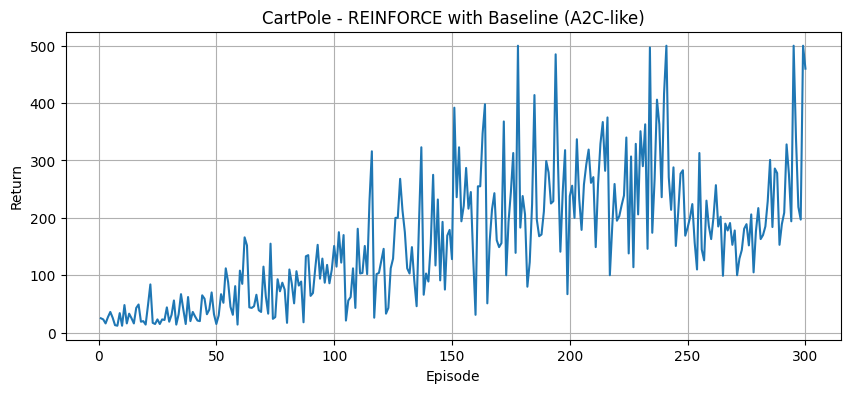

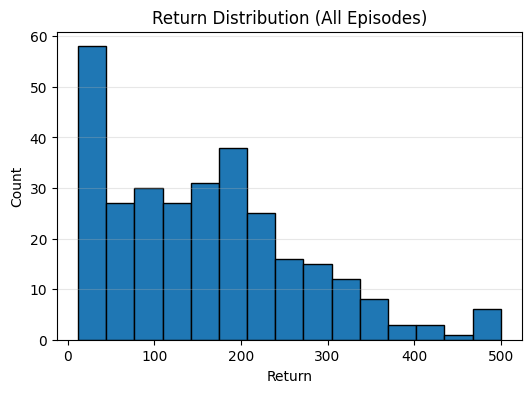

In [11]:
# MLP로 정책 근사 / policy 학습 및, Value Function Baseline 학습

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ENV_ID = "CartPole-v1"
NUM_EPISODES = 300
MAX_STEPS = 500
GAMMA = 0.99
LR_POLICY = 1e-3
LR_VALUE = 1e-3

class PolicyNet(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)

class ValueNet(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

def compute_returns(rewards, gamma=0.99):
    G = 0.0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns.reverse()
    return returns

def main():
    env = gym.make(ENV_ID)
    policy = PolicyNet().to(device)
    value = ValueNet().to(device)

    opt_pi = optim.Adam(policy.parameters(), lr=LR_POLICY)
    opt_v  = optim.Adam(value.parameters(), lr=LR_VALUE)

    all_returns = []

    for ep in range(1, NUM_EPISODES + 1):
        state, info = env.reset()
        log_probs = []
        rewards = []
        states = []

        for t in range(MAX_STEPS):
            s_t = torch.as_tensor(state, dtype=torch.float32, device=device)
            probs = policy(s_t)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, terminated, truncated, info = env.step(action.item())

            states.append(s_t)
            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state
            if terminated or truncated:
                break

        returns = compute_returns(rewards, GAMMA)
        R = torch.tensor(returns, dtype=torch.float32, device=device)
        S = torch.stack(states)
        log_probs_t = torch.stack(log_probs)

        # baseline: V(s)
        V = value(S)
        advantage = R - V.detach()

        # Policy loss: -E[log pi * A]
        loss_pi = -(log_probs_t * advantage).sum()

        # Value loss: MSE(R, V)
        loss_v = ((R - V)**2).mean()

        opt_pi.zero_grad()
        loss_pi.backward()
        opt_pi.step()

        opt_v.zero_grad()
        loss_v.backward()
        opt_v.step()

        ep_return = sum(rewards)
        all_returns.append(ep_return)

        if ep % 50 == 0:
            print(f"[REINFORCE+Baseline] Ep {ep}, Return {ep_return}, "
                  f"Avg(50): {np.mean(all_returns[-50:]):.2f}")

    env.close()

    torch.save(policy.state_dict(), "cartpole_reinforce_policy.pth")
    torch.save(value.state_dict(),  "cartpole_reinforce_value.pth")
    print("Policy + Value saved to cartpole_reinforce_*.pth")

    xs = np.arange(1, NUM_EPISODES + 1)
    plt.figure(figsize=(10,4))
    plt.plot(xs, all_returns)
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title("CartPole - REINFORCE with Baseline (A2C-like)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(all_returns, bins=15, edgecolor="black")
    plt.xlabel("Return")
    plt.ylabel("Count")
    plt.title("Return Distribution (All Episodes)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

if __name__ == "__main__":
    main()


[DQN] Episode 20, Return 12.0, Avg(20): 20.80, eps=0.611
[DQN] Episode 40, Return 11.0, Avg(20): 12.55, eps=0.486
[DQN] Episode 60, Return 13.0, Avg(20): 15.00, eps=0.373
[DQN] Episode 80, Return 17.0, Avg(20): 20.70, eps=0.264
[DQN] Episode 100, Return 500.0, Avg(20): 98.15, eps=0.080
[DQN] Episode 120, Return 339.0, Avg(20): 399.90, eps=0.050
[DQN] Episode 140, Return 324.0, Avg(20): 328.05, eps=0.050
[DQN] Episode 160, Return 470.0, Avg(20): 366.40, eps=0.050
[DQN] Episode 180, Return 277.0, Avg(20): 393.70, eps=0.050
[DQN] Episode 200, Return 500.0, Avg(20): 365.10, eps=0.050
[DQN] Episode 220, Return 500.0, Avg(20): 353.60, eps=0.050
[DQN] Episode 240, Return 491.0, Avg(20): 299.25, eps=0.050
[DQN] Episode 260, Return 179.0, Avg(20): 200.90, eps=0.050
[DQN] Episode 280, Return 186.0, Avg(20): 189.25, eps=0.050
[DQN] Episode 300, Return 203.0, Avg(20): 226.30, eps=0.050
DQN model saved to cartpole_dqn.pth


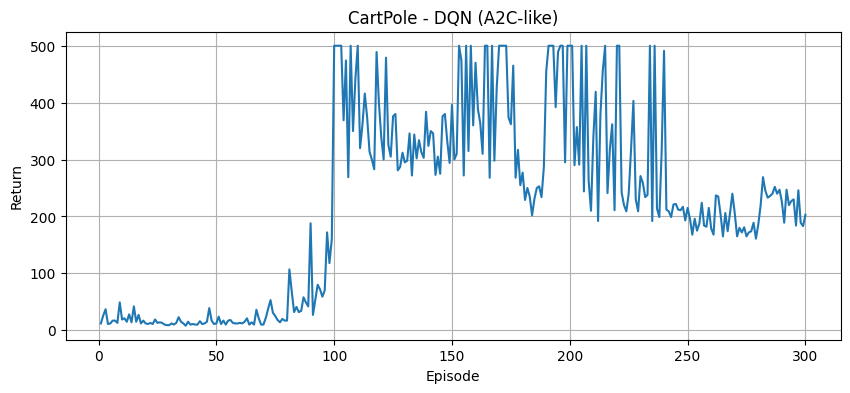

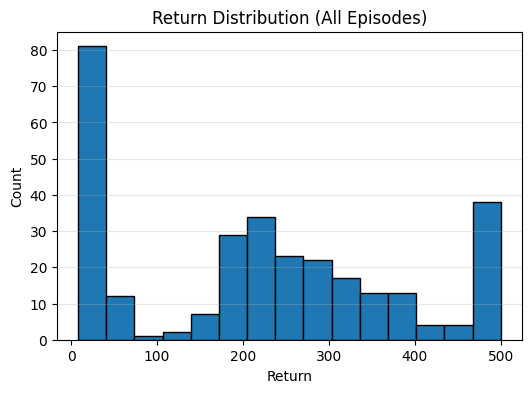

In [15]:
# DQN의 Idea
# 학습을 할 때, 바로 직전의 경험인 상관 데이터로 이어지면 학습이 불안정 해진다.
# 그래서 경험을 버퍼에 저장 한 뒤, 무작위 미니배치로 샘플링해서 학습
# 데이터의 상관 관계가 감소 (독립적에 가까워짐)
# Q-Learning 업데이트 할 때, Q(s, a) <- r + rmax(s', a') 로 학습 하게 되는데
# Q 에 자기 자신을 넣어서 업데이트 할 때는 문제가 self-target 문제 때문에 발산하기 쉽다.
# 그래서 Q를 두개로 분리해서, 학습용 네트워크와, 고정된 Q-target 산출용 네트워크를 두고
# 일정 시간마다 Q-target network를 한번에 업데이트 한다
# 이렇게 해서 타겟이 안정적이고, loss 가 폭주하는 문제가 해결이 된다.

import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENV_ID = "CartPole-v1"
NUM_EPISODES = 300
MAX_STEPS = 500
GAMMA = 0.97
LR = 1e-4
BUFFER_SIZE = 10000
BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TARGET_UPDATE = 10

class QNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def push(self, s, a, r, ns, d):
        self.buffer.append((s, a, r, ns, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = map(np.array, zip(*batch))
        return s, a, r, ns, d

    def __len__(self):
        return len(self.buffer)

def epsilon_by_frame(frame_idx):
    return EPS_END + (EPS_START - EPS_END) * np.exp(-1. * frame_idx / EPS_DECAY)

def main():
    env = gym.make(ENV_ID)

    q_net = QNet().to(device)
    target_net = QNet().to(device)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=LR)
    replay = ReplayBuffer(BUFFER_SIZE)

    all_returns = []
    frame_idx = 0

    for ep in range(1, NUM_EPISODES + 1):
        state, info = env.reset()
        ep_return = 0

        for t in range(MAX_STEPS):
            frame_idx += 1
            eps = epsilon_by_frame(frame_idx)

            # epsilon-greedy
            if random.random() < eps:
                action = env.action_space.sample()
            else:
                s_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                with torch.no_grad():
                    q_vals = q_net(s_t)
                action = int(torch.argmax(q_vals, dim=1).item())

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            replay.push(state, action, reward, next_state, done)

            state = next_state
            ep_return += reward

            # 학습
            if len(replay) >= BATCH_SIZE:
                s, a, r, ns, d = replay.sample(BATCH_SIZE)

                s_t  = torch.as_tensor(s,  dtype=torch.float32, device=device)
                a_t  = torch.as_tensor(a,  dtype=torch.int64,   device=device).unsqueeze(-1)
                r_t  = torch.as_tensor(r,  dtype=torch.float32, device=device)
                ns_t = torch.as_tensor(ns, dtype=torch.float32, device=device)
                d_t  = torch.as_tensor(d,  dtype=torch.float32, device=device)

                q_values = q_net(s_t).gather(1, a_t).squeeze(-1)

                with torch.no_grad():
                    next_q = target_net(ns_t).max(dim=1)[0]
                    target = r_t + GAMMA * next_q * (1.0 - d_t)

                loss = ((q_values - target)**2).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        all_returns.append(ep_return)

        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(q_net.state_dict())

        if ep % 20 == 0:
            print(f"[DQN] Episode {ep}, Return {ep_return}, "
                  f"Avg(20): {np.mean(all_returns[-20:]):.2f}, eps={eps:.3f}")

    env.close()

    torch.save(q_net.state_dict(), "cartpole_dqn.pth")
    print("DQN model saved to cartpole_dqn.pth")

    xs = np.arange(1, NUM_EPISODES + 1)
    plt.figure(figsize=(10,4))
    plt.plot(xs, all_returns)
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title("CartPole - DQN (A2C-like)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(all_returns, bins=15, edgecolor="black")
    plt.xlabel("Return")
    plt.ylabel("Count")
    plt.title("Return Distribution (All Episodes)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

if __name__ == "__main__":
    main()


### DQN은 행동 (action) 이 이산적일대만 사용 할 수 있는 문제가 있었다.
 - 연속 행동은 DQN으로는 직접 처리 불가
 -  A2C의 해결: 정책 π(a|s) 자체를 neural network로 표현 → 연속 행동도 가능

### DQN의 또 다른 문제 — Q-value의 over estimation / bootstrap 불안정성
  -  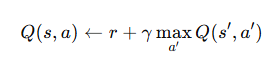
  - 함수식을 업데이트 하는 과정에서 max 를 사용해서 Q-value가 너무 크게 커지는 문제가 있다.
  - target-network 필수 (폭발 방지) - 뉴럴 네트워크를 두개를 유지해야 함.

### A2C의 해결: Advantage 기반 업데이트 → 훨씬 안정적
  - 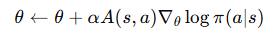
  - 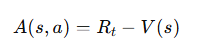
  - baseline V(s)가 노이즈를 줄인다.
  - variance가 감소된다.
  - 업데이트가 안정화된다.
  - over estimation (과추측)이 줄어든다.

### DQN의 문제 3 — Off-policy + Replay Buffer 때문에 속도가 느림
 - DQN은 Experience Delay (지연학습) 을 위해서
  - 데이터를 버퍼에 쌓고 샘플링 해서 여러번 재사용 했다.
  - 이 과정때문에 gpu 병렬화가 어렵고, 속도가 느리고, 구현이 복잡했다.

### A2C의 해결: On-policy → Replay Buffer 필요 없음
 - 그냥 경험을 수집해서 바로 업데이트 한다.
   - 대신 여러 actor 를 환경별로 실행한다.
     - Replay Buffer 가 필요 없고 학습 속도가 빨라짐
     - 병렬화가 쉬워진다.

### DQN의 문제
 - 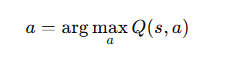
 - 탐색을 오롯히 `ε-greedy` 즉, 랜덤한 고정된 값에 의존
 - gradient 기반 policy improvement 가 이루어지지 않는다.


### A2C에서는...
 - 탐색을 자연스럽게 포함
  - entropy bonus를 넣어 더 강하게 탐색할 수 있음
  - continuous & flexible exploration


  | 항목          | DQN                                  | A2C                               |
| ----------- | ------------------------------------ | --------------------------------- |
| 행동          | 이산만 가능                               | 이산/연속 모두 가능                       |
| 업데이트        | Q-learning 기반, bootstrap             | 정책 gradient 기반                    |
| 안정성         | overestimation 문제, target network 필요 | baseline으로 variance 감소, 자연스럽게 안정적 |
| exploration | ε-greedy만                            | 확률적 정책 + entropy                  |
| 데이터         | Replay Buffer 필요                     | Replay Buffer 없음                  |
| 속도          | 느림 (off-policy)                      | 빠름 (on-policy + 병렬)               |
| 확장성         | CNN Atari는 잘함, continuous에 약함        | 연속 제어 환경까지 커버                     |


[A2C parallel] Episodes 120/10000, Last return: 43.0, Avg(20): 21.60
[A2C parallel] Episodes 220/10000, Last return: 10.0, Avg(20): 14.35
[A2C parallel] Episodes 300/10000, Last return: 12.0, Avg(20): 12.95
[A2C parallel] Episodes 460/10000, Last return: 10.0, Avg(20): 12.30
[A2C parallel] Episodes 500/10000, Last return: 12.0, Avg(20): 13.20
[A2C parallel] Episodes 600/10000, Last return: 9.0, Avg(20): 13.15
[A2C parallel] Episodes 640/10000, Last return: 15.0, Avg(20): 13.50
[A2C parallel] Episodes 780/10000, Last return: 10.0, Avg(20): 12.30
[A2C parallel] Episodes 900/10000, Last return: 15.0, Avg(20): 11.25
[A2C parallel] Episodes 1100/10000, Last return: 10.0, Avg(20): 11.15
[A2C parallel] Episodes 1300/10000, Last return: 10.0, Avg(20): 10.70
[A2C parallel] Episodes 1460/10000, Last return: 10.0, Avg(20): 10.90
[A2C parallel] Episodes 1540/10000, Last return: 16.0, Avg(20): 11.15
[A2C parallel] Episodes 1640/10000, Last return: 10.0, Avg(20): 11.70
[A2C parallel] Episodes 2300/1

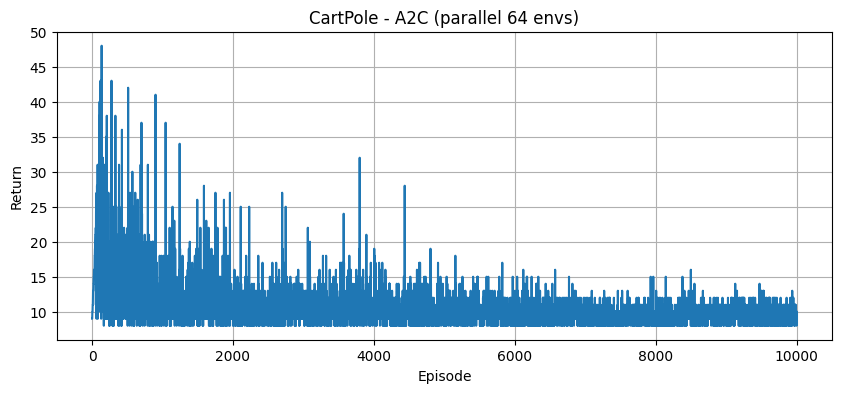

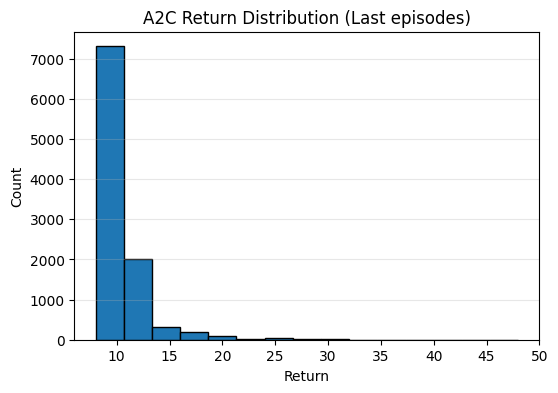

In [38]:
import gymnasium as gym
from gymnasium.vector import SyncVectorEnv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENV_ID = "CartPole-v1"
NUM_EPISODES = 10000        # 전체 에피소드 수 (env 전부 합쳐서)
MAX_STEPS_PER_EP = 500
GAMMA = 0.99
LR = 1e-3
N_ENVS = 64                # 병렬 환경 개수

class ActorCritic(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(4, hidden),
            nn.Tanh(),
        )
        self.policy_head = nn.Linear(hidden, 2)   # action 2개
        self.value_head  = nn.Linear(hidden, 1)   # V(s)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        h = self.shared(x)
        logits = self.policy_head(h)
        value  = self.value_head(h).squeeze(-1)
        probs = torch.softmax(logits, dim=-1)
        return probs, value

    def act_eval(self, state):
        s = torch.as_tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            probs, _ = self.forward(s)
        dist = torch.distributions.Categorical(probs)
        return dist.sample().item()


def make_env():
    return gym.make(ENV_ID)

def main():
    # 병렬 환경 생성
    envs = SyncVectorEnv([make_env for _ in range(N_ENVS)])
    ac = ActorCritic().to(device)
    optimizer = optim.Adam(ac.parameters(), lr=LR)

    obs, infos = envs.reset()
    obs = np.array(obs, dtype=np.float32)

    running_returns = np.zeros(N_ENVS, dtype=np.float32)
    all_returns = []
    episodes_done = 0
    step_count = 0

    while episodes_done < NUM_EPISODES:
        step_count += 1

        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device)
        probs, values = ac(obs_t)

        dist = torch.distributions.Categorical(probs)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()

        actions_np = actions.cpu().numpy()
        next_obs, rewards, terminated, truncated, infos = envs.step(actions_np)

        rewards = np.array(rewards, dtype=np.float32)
        dones = np.logical_or(terminated, truncated)

        # 리턴 누적
        running_returns += rewards

        with torch.no_grad():
            next_obs_t = torch.as_tensor(next_obs, dtype=torch.float32, device=device)
            _, next_values = ac(next_obs_t)

            dones_t    = torch.as_tensor(dones,    dtype=torch.float32, device=device)
            rewards_t  = torch.as_tensor(rewards,  dtype=torch.float32, device=device)

            td_target  = rewards_t + GAMMA * next_values * (1.0 - dones_t)
            advantages = td_target - values

        actor_loss  = -(log_probs * advantages.detach()).mean()
        critic_loss = advantages.pow(2).mean()
        loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        obs = next_obs

        if np.any(dones):
            for i in range(N_ENVS):
                if dones[i]:
                    episodes_done += 1
                    all_returns.append(running_returns[i])
                    running_returns[i] = 0.0

        # 너무 오래 도는 것 방지용
        if step_count > NUM_EPISODES * MAX_STEPS_PER_EP:
            print("WARN: step limit reached, stopping early.")
            break

        if episodes_done >= 20 and episodes_done % 20 == 0 and np.any(dones):
            print(f"[A2C parallel] Episodes {episodes_done}/{NUM_EPISODES}, "
                  f"Last return: {all_returns[-1]:.1f}, "
                  f"Avg(20): {np.mean(all_returns[-20:]):.2f}")

    envs.close()

    all_returns = np.array(all_returns[:NUM_EPISODES], dtype=np.float32)
    print("Total episodes collected:", len(all_returns))

    torch.save(ac.state_dict(), "cartpole_a2c.pth")
    print("A2C (parallel) model saved to cartpole_a2c.pth")

    xs = np.arange(1, len(all_returns) + 1)
    plt.figure(figsize=(10,4))
    plt.plot(xs, all_returns)
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title(f"CartPole - A2C (parallel {N_ENVS} envs)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(all_returns, bins=15, edgecolor="black")
    plt.xlabel("Return"); plt.ylabel("Count")
    plt.title("A2C Return Distribution (Last episodes)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


if __name__ == "__main__":
    main()


In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

ENV_ID = "CartPole-v1"
MAX_STEPS = 500
FPS = 60

class RandomPolicy:
    def act(self, state):
        return np.random.randint(0, 2)


class LinearPolicyWrapper:
    def __init__(self, weight_vec):
        self.W = weight_vec

    def act(self, state):
        return 1 if np.dot(self.W, state) > 0 else 0


class MLPPolicyPG(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
        )
    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)

    def act(self, state):
        s = torch.as_tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            probs = self.forward(s)
        dist = torch.distributions.Categorical(probs)
        return dist.sample().item()


class PolicyNetReinforce(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )
    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)

    def act(self, state):
        s = torch.as_tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            probs = self.forward(s)
        dist = torch.distributions.Categorical(probs)
        return dist.sample().item()


class DQNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )
    def forward(self, x):
        return self.net(x)

    def act(self, state):
        s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q = self.forward(s)
        return int(q.argmax(dim=1).item())


class ActorCritic(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(4, hidden),
            nn.Tanh(),
        )
        self.policy_head = nn.Linear(hidden, 2)
        self.value_head  = nn.Linear(hidden, 1)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        h = self.shared(x)
        logits = self.policy_head(h)
        probs = torch.softmax(logits, dim=-1)
        value = self.value_head(h).squeeze(-1)
        return probs, value

    def act(self, state):
        s = torch.as_tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            probs, _ = self.forward(s)
        dist = torch.distributions.Categorical(probs)
        return dist.sample().item()

import pickle
def load_policy(name):
    print(f"Loading model: {name}")

    if name == "random":
        return RandomPolicy()

    if name == "linear":
        with open("linear_policy_bestW.pkl", "rb") as f:
            W = pickle.load(f)
        return LinearPolicyWrapper(W)

    if name == "mlp_pg":
        model = MLPPolicyPG().to(device)
        model.load_state_dict(torch.load("cartpole_mlp_pg.pth", map_location=device))
        model.eval()
        return model

    if name == "reinforce":
        model = PolicyNetReinforce().to(device)
        model.load_state_dict(torch.load("cartpole_reinforce_policy.pth", map_location=device))
        model.eval()
        return model

    if name == "dqn":
        model = DQNNet().to(device)
        model.load_state_dict(torch.load("cartpole_dqn.pth", map_location=device))
        model.eval()
        return model

    if name == "a2c":
        model = ActorCritic().to(device)
        model.load_state_dict(torch.load("cartpole_a2c.pth", map_location=device))
        model.eval()
        return model

    raise ValueError(f"Unknown policy: {name}")


def run_episodes(policy, num_episodes=10, render=False):
    env = gym.make(ENV_ID, render_mode="human" if render else None)
    returns = []

    dt = 1.0 / FPS

    for ep in range(num_episodes):
        state, info = env.reset()
        ep_return = 0

        for t in range(MAX_STEPS):
            action = policy.act(state)
            state, reward, terminated, truncated, info = env.step(action)
            ep_return += reward

            if render:
                env.render()
                time.sleep(dt)

            if terminated or truncated:
                break

        returns.append(ep_return)
        print(f"Episode {ep+1}: {ep_return}")

    env.close()
    return np.array(returns)

def visualize_returns(returns, title):
    xs = np.arange(1, len(returns) + 1)

    plt.figure(figsize=(10,4))
    plt.plot(xs, returns, marker='o')
    plt.title(f"{title} — Episode Returns")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(returns, bins=max(5, len(returns)//2), edgecolor="black")
    plt.title(f"{title} — Return Histogram")
    plt.xlabel("Return")
    plt.ylabel("Count")
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

Device: cuda


Loading model: random
Episode 1: 14.0
Episode 2: 18.0
Episode 3: 22.0
Episode 4: 9.0
Episode 5: 26.0
Episode 6: 13.0
Episode 7: 19.0
Episode 8: 25.0
Episode 9: 10.0
Episode 10: 32.0
Episode 11: 36.0
Episode 12: 14.0
Episode 13: 14.0
Episode 14: 19.0
Episode 15: 14.0
Episode 16: 40.0
Episode 17: 24.0
Episode 18: 19.0
Episode 19: 21.0
Episode 20: 18.0


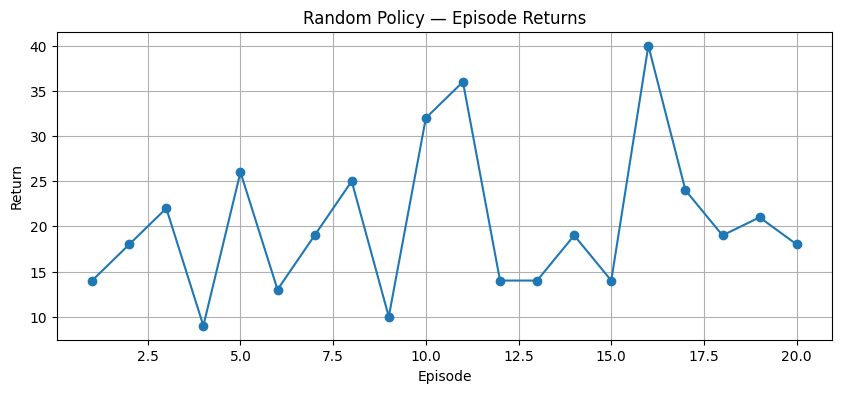

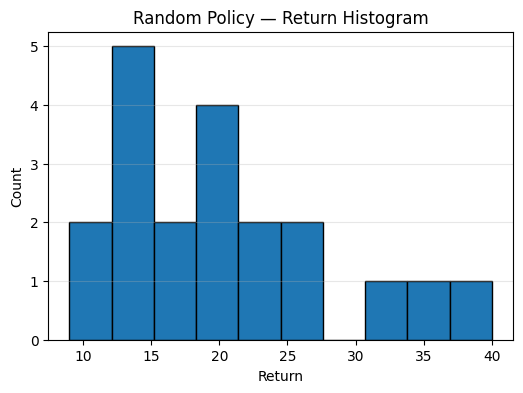

In [4]:
policy = load_policy("random")
ret = run_episodes(policy, 20, render=True)
visualize_returns(ret, "Random Policy")

Loading model: linear
Episode 1: 486.0
Episode 2: 422.0
Episode 3: 468.0
Episode 4: 471.0
Episode 5: 500.0


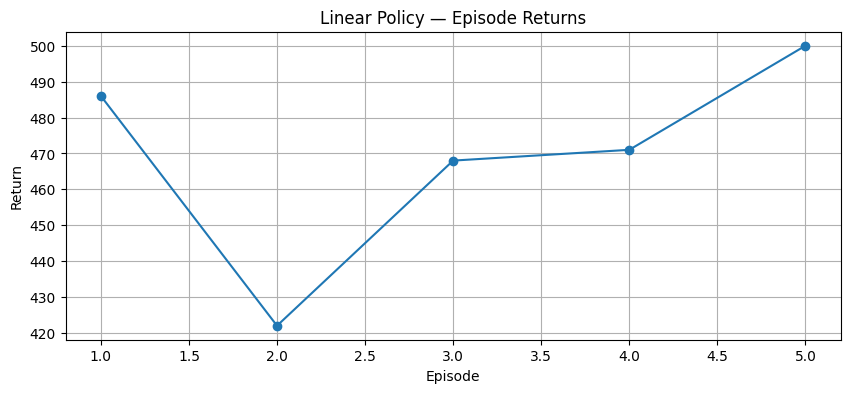

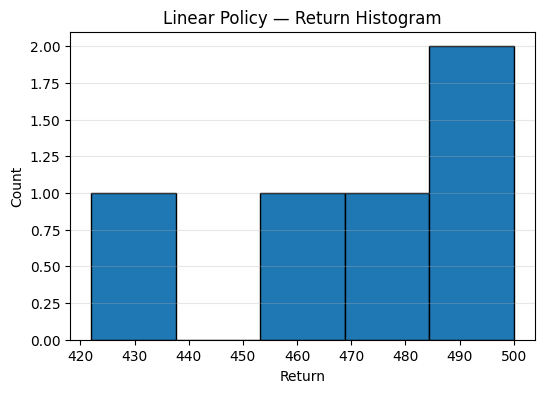

In [5]:
policy = load_policy("linear")
ret = run_episodes(policy, 5, render=True)
visualize_returns(ret, "Linear Policy")

Loading model: mlp_pg
Episode 1: 49.0
Episode 2: 79.0
Episode 3: 80.0
Episode 4: 67.0
Episode 5: 57.0


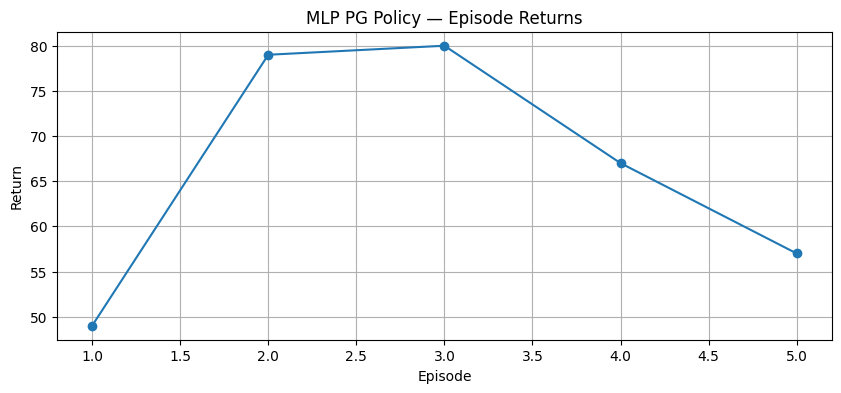

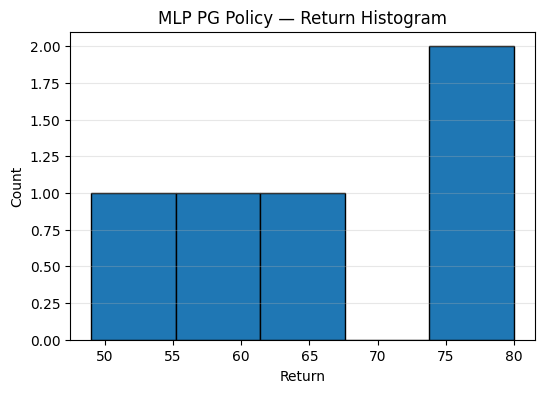

In [6]:
policy = load_policy("mlp_pg")
ret = run_episodes(policy, 5, render=True)
visualize_returns(ret, "MLP PG Policy")

Loading model: reinforce
Episode 1: 223.0
Episode 2: 254.0
Episode 3: 500.0
Episode 4: 91.0
Episode 5: 494.0


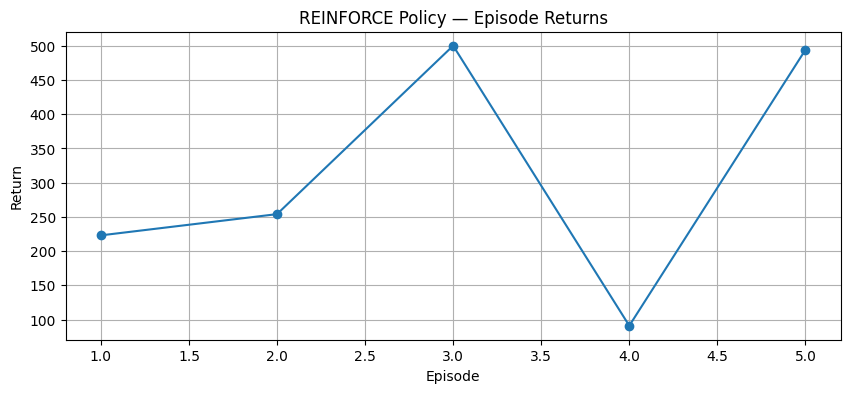

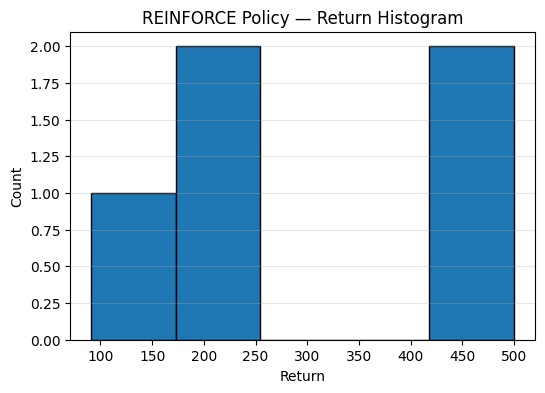

In [7]:
policy = load_policy("reinforce")
ret = run_episodes(policy, 5, render=True)
visualize_returns(ret, "REINFORCE Policy")

Loading model: dqn
Episode 1: 264.0
Episode 2: 211.0
Episode 3: 310.0
Episode 4: 243.0
Episode 5: 203.0


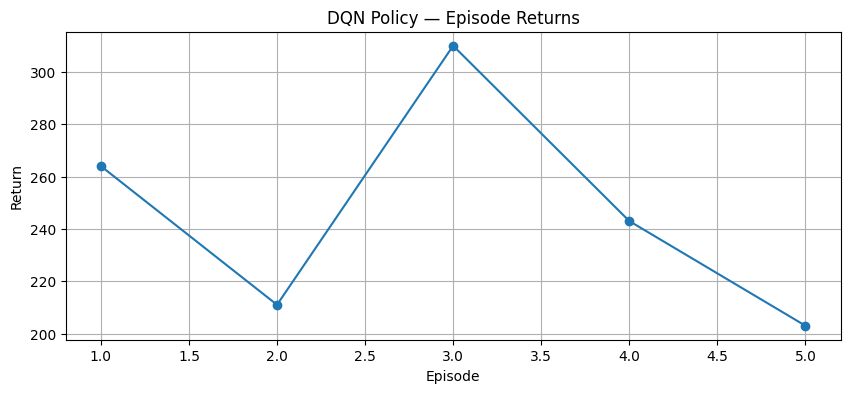

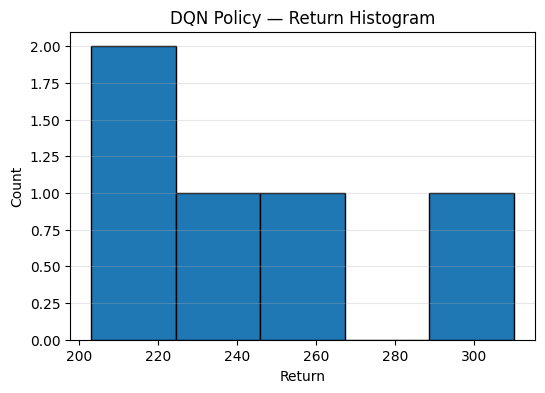

In [8]:
policy = load_policy("dqn")
ret = run_episodes(policy, 5, render=True)
visualize_returns(ret, "DQN Policy")

Loading model: a2c
Episode 1: 8.0
Episode 2: 10.0
Episode 3: 10.0
Episode 4: 10.0
Episode 5: 12.0
Episode 6: 9.0
Episode 7: 11.0
Episode 8: 9.0
Episode 9: 12.0
Episode 10: 11.0
Episode 11: 9.0
Episode 12: 9.0
Episode 13: 9.0
Episode 14: 9.0
Episode 15: 13.0
Episode 16: 10.0
Episode 17: 10.0
Episode 18: 9.0
Episode 19: 10.0
Episode 20: 9.0


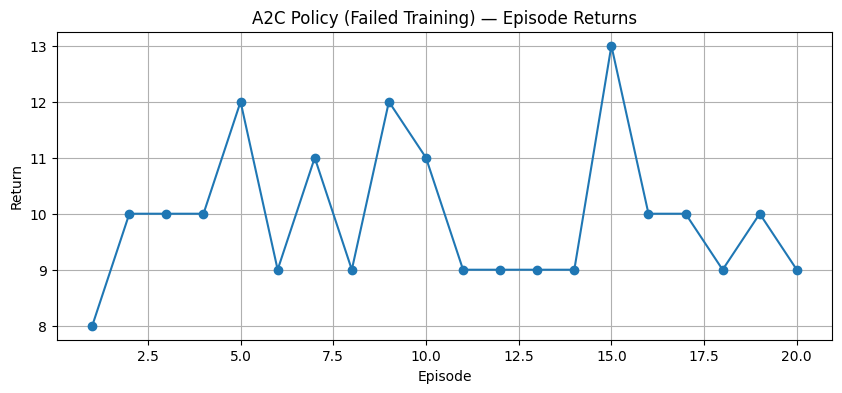

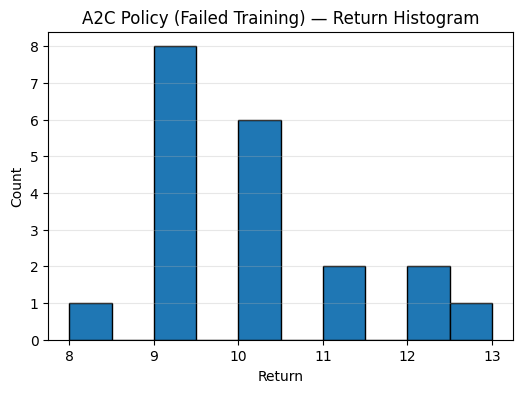

In [9]:
policy = load_policy("a2c")
ret = run_episodes(policy, 20, render=True)
visualize_returns(ret, "A2C Policy (Failed Training)")

모델이 크다고, 그리고 최신 알고리즘이라고 해서, 모든 문제를 더 빠르고 잘 학습하는 것은 아니다.
 - 찾기가 어려울 수도 있고, 시간이 많이 들어갈 수도 있고, 자원을 많이 써야할 수도 있다.

CartPole처럼 문제 자체가 단순한 경우 (선형분리가 가능한 경우)
 - Linear Policy(가장 단순한 모델) 가 다른 복잡한 모델들보다 더 잘 동작한다.

반대로, 복잡한 이미지나 자연어 문제라면
 - → 선형 모델은 절대 풀 수 없고 딥러닝이 필수다.
 - 이게 간단한 모델로 안 된다는것은 이미 앞에서 CNN 등으로 충분히 보여줬다.

이 실험을 통해 확인할 수 있는 중요한 사실:

머신러닝은 `최신 모델`을 쓰는 일이 아니라
`문제에 맞는 모델`을 선택하는 일이 훨씬 더 중요하다.

적절한 모델 구조

적절한 파라미터 수

적절한 데이터/환경

적절한 학습 전략

을 고르는 능력이 실무에서 가장 중요한 역량이다.